<a href="https://colab.research.google.com/github/payalbhatia/EVA/blob/master/EVA4S5_2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
import torchvision
import PIL
train_transforms = torchvision.transforms.Compose([
            # torchvision.transforms.Resize((28, 28)),
            torchvision.transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            # torchvision.transforms.RandomHorizontalFlip(),
            # torchvision.transforms.RandomRotation(30,),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
            ])
test_transforms = torchvision.transforms.Compose([
            # torchvision.transforms.Resize((28, 28)),
            torchvision.transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            # torchvision.transforms.RandomHorizontalFlip(),
            # torchvision.transforms.RandomRotation(30,),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
            ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [36]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

NameError: ignored

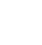

In [38]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [40]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [44]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0




Loss=2.3208253383636475 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=2.3208253383636475 Batch_id=0 Accuracy=7.81:   0%|          | 1/469 [00:00<03:23,  2.30it/s]

Loss=2.3210043907165527 Batch_id=1 Accuracy=8.20:   0%|          | 1/469 [00:00<03:23,  2.30it/s]

Loss=2.308687925338745 Batch_id=2 Accuracy=8.85:   0%|          | 1/469 [00:00<03:23,  2.30it/s] 

Loss=2.312361478805542 Batch_id=3 Accuracy=8.40:   0%|          | 1/469 [00:00<03:23,  2.30it/s]

Loss=2.3006207942962646 Batch_id=4 Accuracy=8.59:   0%|          | 1/469 [00:00<03:23,  2.30it/s]

Loss=2.3006207942962646 Batch_id=4 Accuracy=8.59:   1%|          | 5/469 [00:00<02:27,  3.14it/s]

Loss=2.3022639751434326 Batch_id=5 Accuracy=8.20:   1%|          | 5/469 [00:00<02:27,  3.14it/s]

Loss=2.28464674949646 Batch_id=6 Accuracy=9.38:   1%|          | 5/469 [00:00<02:27,  3.14it/s]  

Loss=2.277346611022949 Batch_id=7 Accuracy=9.28:   1%|          | 5/469 [00:00<02:27,  3.14it/s]

Loss=2.27449750900


Test set: Average loss: 0.5647, Accuracy: 8606/10000 (86.06%)

EPOCH: 1




Loss=0.41476255655288696 Batch_id=0 Accuracy=94.53:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.41476255655288696 Batch_id=0 Accuracy=94.53:   0%|          | 1/469 [00:00<03:05,  2.52it/s]

Loss=0.38316482305526733 Batch_id=1 Accuracy=94.14:   0%|          | 1/469 [00:00<03:05,  2.52it/s]

Loss=0.43581753969192505 Batch_id=2 Accuracy=92.97:   0%|          | 1/469 [00:00<03:05,  2.52it/s]

Loss=0.3344801962375641 Batch_id=3 Accuracy=92.58:   0%|          | 1/469 [00:00<03:05,  2.52it/s] 

Loss=0.34777921438217163 Batch_id=4 Accuracy=93.28:   0%|          | 1/469 [00:00<03:05,  2.52it/s]

Loss=0.34777921438217163 Batch_id=4 Accuracy=93.28:   1%|          | 5/469 [00:00<02:12,  3.49it/s]

Loss=0.38435548543930054 Batch_id=5 Accuracy=92.97:   1%|          | 5/469 [00:00<02:12,  3.49it/s]

Loss=0.3892362415790558 Batch_id=6 Accuracy=92.97:   1%|          | 5/469 [00:00<02:12,  3.49it/s] 

Loss=0.33587759733200073 Batch_id=7 Accuracy=93.07:   1%|          | 5/469 [00:00<02:12,  3.49it/


Test set: Average loss: 0.3708, Accuracy: 9012/10000 (90.12%)

EPOCH: 2




Loss=0.18169660866260529 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.18169660866260529 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:17,  3.39it/s]

Loss=0.22914940118789673 Batch_id=1 Accuracy=95.31:   0%|          | 1/469 [00:00<02:17,  3.39it/s]

Loss=0.22914940118789673 Batch_id=1 Accuracy=95.31:   0%|          | 2/469 [00:00<01:59,  3.90it/s]

Loss=0.19368015229701996 Batch_id=2 Accuracy=95.57:   0%|          | 2/469 [00:00<01:59,  3.90it/s]

Loss=0.2141457498073578 Batch_id=3 Accuracy=95.51:   0%|          | 2/469 [00:00<01:59,  3.90it/s] 

Loss=0.20580539107322693 Batch_id=4 Accuracy=95.47:   0%|          | 2/469 [00:00<01:59,  3.90it/s]

Loss=0.20580539107322693 Batch_id=4 Accuracy=95.47:   1%|          | 5/469 [00:00<01:28,  5.25it/s]

Loss=0.18270310759544373 Batch_id=5 Accuracy=95.31:   1%|          | 5/469 [00:00<01:28,  5.25it/s]

Loss=0.16734661161899567 Batch_id=6 Accuracy=95.54:   1%|          | 5/469 [00:00<01:28,  5.25it/


Test set: Average loss: 0.1604, Accuracy: 9672/10000 (96.72%)

EPOCH: 3




Loss=0.10539285093545914 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.10539285093545914 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:34,  2.18it/s]

Loss=0.14807607233524323 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<03:34,  2.18it/s]

Loss=0.17814812064170837 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<03:34,  2.18it/s]

Loss=0.09973324090242386 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<03:34,  2.18it/s]

Loss=0.12179091572761536 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<03:34,  2.18it/s]

Loss=0.12179091572761536 Batch_id=4 Accuracy=97.97:   1%|          | 5/469 [00:00<02:35,  2.99it/s]

Loss=0.1388164758682251 Batch_id=5 Accuracy=97.66:   1%|          | 5/469 [00:00<02:35,  2.99it/s] 

Loss=0.17684519290924072 Batch_id=6 Accuracy=97.21:   1%|          | 5/469 [00:00<02:35,  2.99it/s]

Loss=0.12472748011350632 Batch_id=7 Accuracy=97.27:   1%|          | 5/469 [00:00<02:35,  2.99it/


Test set: Average loss: 0.1566, Accuracy: 9678/10000 (96.78%)

EPOCH: 4




Loss=0.10656247287988663 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.10656247287988663 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<03:07,  2.49it/s]

Loss=0.11693838238716125 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<03:07,  2.49it/s]

Loss=0.11319012194871902 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<03:07,  2.49it/s]

Loss=0.1226992979645729 Batch_id=3 Accuracy=97.07:   0%|          | 1/469 [00:00<03:07,  2.49it/s] 

Loss=0.1226992979645729 Batch_id=3 Accuracy=97.07:   1%|          | 4/469 [00:00<02:15,  3.43it/s]

Loss=0.10151012241840363 Batch_id=4 Accuracy=97.34:   1%|          | 4/469 [00:00<02:15,  3.43it/s]

Loss=0.12577885389328003 Batch_id=5 Accuracy=97.40:   1%|          | 4/469 [00:00<02:15,  3.43it/s]

Loss=0.12577885389328003 Batch_id=5 Accuracy=97.40:   1%|▏         | 6/469 [00:00<01:43,  4.46it/s]

Loss=0.11141394823789597 Batch_id=6 Accuracy=97.66:   1%|▏         | 6/469 [00:00<01:43,  4.46it/s


Test set: Average loss: 0.1417, Accuracy: 9731/10000 (97.31%)

EPOCH: 5




Loss=0.0691865086555481 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.0691865086555481 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:59,  2.61it/s]

Loss=0.1268116682767868 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:59,  2.61it/s]

Loss=0.11772585660219193 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:59,  2.61it/s]

Loss=0.10324591398239136 Batch_id=3 Accuracy=97.27:   0%|          | 1/469 [00:00<02:59,  2.61it/s]

Loss=0.20141340792179108 Batch_id=4 Accuracy=96.88:   0%|          | 1/469 [00:00<02:59,  2.61it/s]

Loss=0.20141340792179108 Batch_id=4 Accuracy=96.88:   1%|          | 5/469 [00:00<02:10,  3.55it/s]

Loss=0.16929462552070618 Batch_id=5 Accuracy=96.88:   1%|          | 5/469 [00:00<02:10,  3.55it/s]

Loss=0.10835954546928406 Batch_id=6 Accuracy=97.10:   1%|          | 5/469 [00:00<02:10,  3.55it/s]

Loss=0.15318377315998077 Batch_id=7 Accuracy=96.88:   1%|          | 5/469 [00:00<02:10,  3.55it/s]



Test set: Average loss: 0.1408, Accuracy: 9699/10000 (96.99%)

EPOCH: 6




Loss=0.06656815111637115 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.06656815111637115 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:01,  2.58it/s]

Loss=0.1092064306139946 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:01,  2.58it/s]  

Loss=0.0737311840057373 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<03:01,  2.58it/s]

Loss=0.06842439621686935 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<03:01,  2.58it/s]

Loss=0.06842439621686935 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<02:11,  3.54it/s]

Loss=0.1164039671421051 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<02:11,  3.54it/s] 

Loss=0.06299430131912231 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<02:11,  3.54it/s]

Loss=0.06299430131912231 Batch_id=5 Accuracy=99.09:   1%|▏         | 6/469 [00:00<01:39,  4.67it/s]

Loss=0.09357397258281708 Batch_id=6 Accuracy=99.00:   1%|▏         | 6/469 [00:00<01:39,  4.67i


Test set: Average loss: 0.1071, Accuracy: 9749/10000 (97.49%)

EPOCH: 7




Loss=0.08853251487016678 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.08853251487016678 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:32,  3.07it/s]

Loss=0.07536935806274414 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:32,  3.07it/s]

Loss=0.048385344445705414 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:32,  3.07it/s]

Loss=0.1089320108294487 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<02:32,  3.07it/s]  

Loss=0.1089320108294487 Batch_id=3 Accuracy=97.85:   1%|          | 4/469 [00:00<01:51,  4.17it/s]

Loss=0.08541464805603027 Batch_id=4 Accuracy=97.97:   1%|          | 4/469 [00:00<01:51,  4.17it/s]

Loss=0.08168065547943115 Batch_id=5 Accuracy=98.05:   1%|          | 4/469 [00:00<01:51,  4.17it/s]

Loss=0.08168065547943115 Batch_id=5 Accuracy=98.05:   1%|▏         | 6/469 [00:00<01:27,  5.32it/s]

Loss=0.13577395677566528 Batch_id=6 Accuracy=98.10:   1%|▏         | 6/469 [00:00<01:27,  5.32it


Test set: Average loss: 0.1043, Accuracy: 9757/10000 (97.57%)

EPOCH: 8




Loss=0.10802154988050461 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.10802154988050461 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<03:00,  2.60it/s]

Loss=0.10280577838420868 Batch_id=1 Accuracy=96.48:   0%|          | 1/469 [00:00<03:00,  2.60it/s]

Loss=0.0926474928855896 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<03:00,  2.60it/s] 

Loss=0.1004173681139946 Batch_id=3 Accuracy=97.07:   0%|          | 1/469 [00:00<03:00,  2.60it/s]

Loss=0.07139798998832703 Batch_id=4 Accuracy=97.50:   0%|          | 1/469 [00:00<03:00,  2.60it/s]

Loss=0.07139798998832703 Batch_id=4 Accuracy=97.50:   1%|          | 5/469 [00:00<02:11,  3.54it/s]

Loss=0.06616547703742981 Batch_id=5 Accuracy=97.66:   1%|          | 5/469 [00:00<02:11,  3.54it/s]

Loss=0.05133133754134178 Batch_id=6 Accuracy=97.77:   1%|          | 5/469 [00:00<02:11,  3.54it/s]

Loss=0.06940943002700806 Batch_id=7 Accuracy=97.75:   1%|          | 5/469 [00:00<02:11,  3.54it/s


Test set: Average loss: 0.1080, Accuracy: 9749/10000 (97.49%)

EPOCH: 9




Loss=0.04764849320054054 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.04764849320054054 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:00,  2.59it/s]

Loss=0.06432618945837021 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:00,  2.59it/s] 

Loss=0.10878792405128479 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<03:00,  2.59it/s]

Loss=0.06588214635848999 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<03:00,  2.59it/s]

Loss=0.06588214635848999 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<02:10,  3.56it/s]

Loss=0.11738361418247223 Batch_id=4 Accuracy=98.44:   1%|          | 4/469 [00:00<02:10,  3.56it/s]

Loss=0.05041593685746193 Batch_id=5 Accuracy=98.57:   1%|          | 4/469 [00:00<02:10,  3.56it/s]

Loss=0.05041593685746193 Batch_id=5 Accuracy=98.57:   1%|▏         | 6/469 [00:00<01:39,  4.65it/s]

Loss=0.05916832759976387 Batch_id=6 Accuracy=98.66:   1%|▏         | 6/469 [00:00<01:39,  4.65


Test set: Average loss: 0.0821, Accuracy: 9813/10000 (98.13%)



Text(0.5, 1.0, 'Test Accuracy')

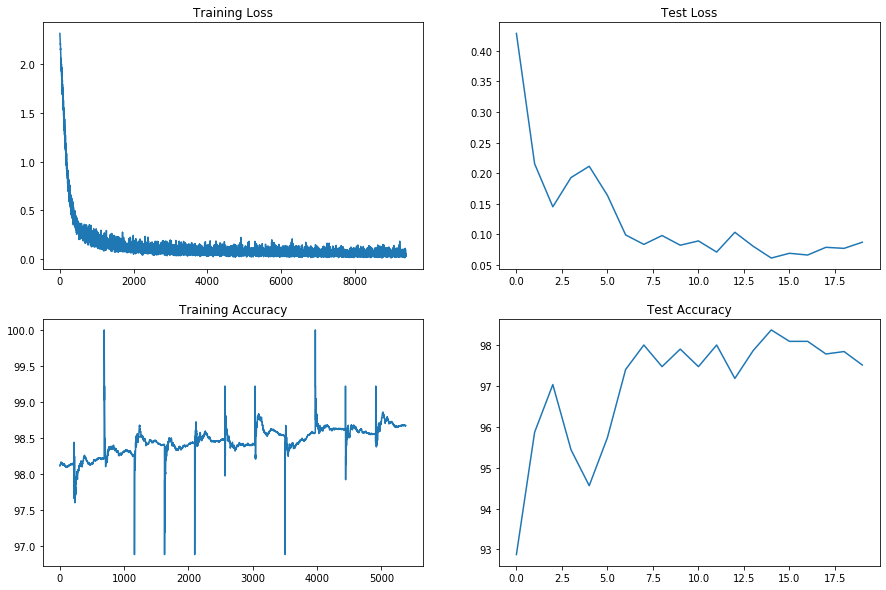

In [43]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")